## Loading data

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

--2024-11-21 20:17:07--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.91, 172.217.7.59, 172.217.12.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   256MB/s    in 0.3s    

2024-11-21 20:17:07 (256 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load ResNet50 without the top layer
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(150, 150, 3),
    pooling='avg',
    weights='imagenet'
)

# Freeze the pretrained model
pretrained_model.trainable = False

# Add custom layers for binary classification
model = models.Sequential([
    pretrained_model,
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.5369 - loss: 0.6925 - val_accuracy: 0.5550 - val_loss: 0.6841
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.5464 - loss: 0.6900 - val_accuracy: 0.5710 - val_loss: 0.6857
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.5380 - loss: 0.6891 - val_accuracy: 0.5580 - val_loss: 0.6828
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.5264 - loss: 0.6890 - val_accuracy: 0.5620 - val_loss: 0.6835
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.5082 - loss: 0.6927 - val_accuracy: 0.5040 - val_loss: 0.6859


In [14]:
pretrained_model.trainable = True

# Compile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 844s 12s/step - accuracy: 0.5075 - loss: 1.4757 - val_accuracy: 0.5200 - val_loss: 0.6880
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 786s 12s/step - accuracy: 0.7379 - loss: 0.5443 - val_accuracy: 0.5110 - val_loss: 0.7768
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 773s 12s/step - accuracy: 0.8605 - loss: 0.3414 - val_accuracy: 0.5280 - val_loss: 0.8129
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 772s 12s/step - accuracy: 0.8772 - loss: 0.2724 - val_accuracy: 0.5360 - val_loss: 1.0128
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 774s 12s/step - accuracy: 0.9045 - loss: 0.2119 - val_accuracy: 0.5000 - val_loss: 1.3831


32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.4789 - loss: 1.4168
Validation Accuracy: 0.50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


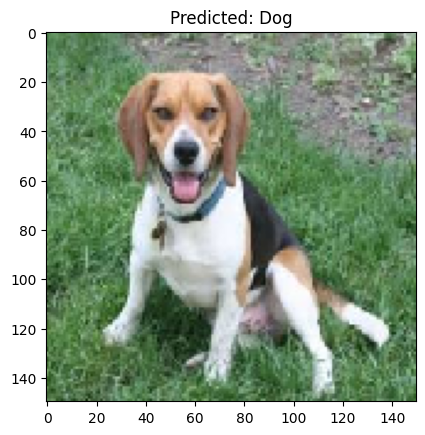

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


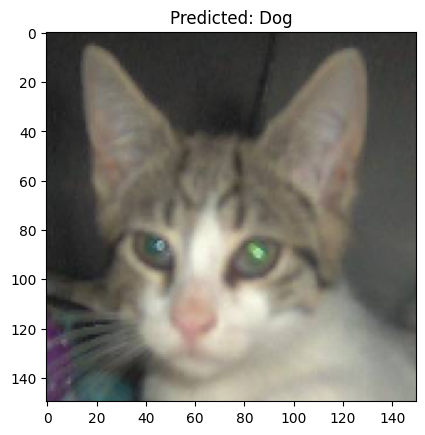

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


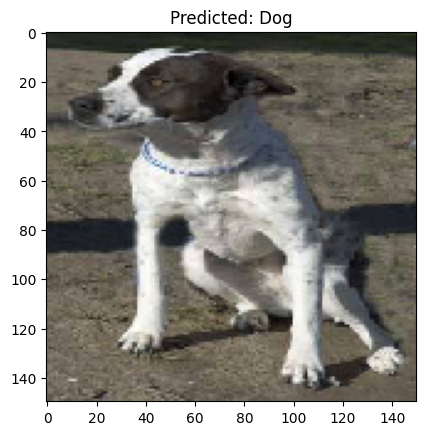

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


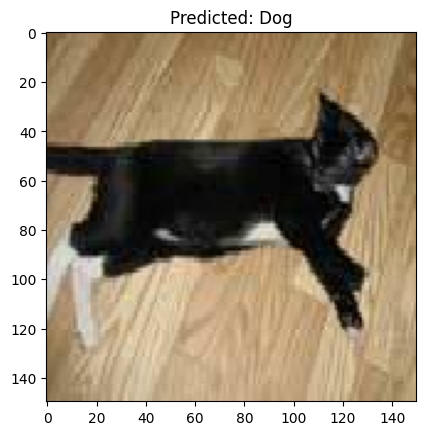

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


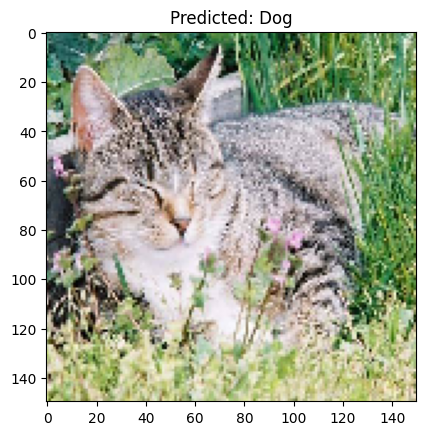

In [15]:
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc:.2f}")

# Step 7: Make predictions
import matplotlib.pyplot as plt
import numpy as np

for i, data in enumerate(validation_generator):
    images, labels = data
    predictions = model.predict(images)
    predictions = [1 if pred > 0.5 else 0 for pred in predictions]

    # Display one example prediction
    plt.imshow(images[0])
    plt.title(f"Predicted: {'Dog' if predictions[0] else 'Cat'}")
    plt.show()

    if i == 4:  # Display predictions for 5 examples
        break

In [16]:
model.save('/tmp/cat_dog_classifier.h5')
print("Model saved to /tmp/cat_dog_classifier.h5")

Model saved to /tmp/cat_dog_classifier.h5
